<h3>Data Description</h3>
<p>
    The `admissions_processed_morphine_sulfate.csv` file is processed as follows, and is a combination of the `PRESCRIPTIONS.csv`, `ADMISSIONS.csv` and `PATIENTS.csv` files found from the MIMIC-III database,
    <ul>
        <li> There are `6618` unique patients. Each patient could have had multiple hospital stays, but we only considered the first hospital stay that the patient had. The rationale is that we wanted a first impression of the patient.
        <li> These 6618 patients comprise four ethnicities: [WHITE, BLACK, ASIAN, HISPANIC] </li>
        <li> The diagnosis that were selected for consideration were only those that were shared by all four ethnic groups, there is a distribution of these diagnostics among each group in the other jupyter notebook. </li>
        <li> Ages were calculated by taking the difference between birthdate and admittime, for ages that were negative due to HIPAA compliance, we readjusted them to all be 89. </li>
        <li> 122 covariates are considered: [age, HOSPITAL_EXPIRE_FLAG, DIAGNOSIS:%s (114 of them), hosp_duration, INSURANCE (5 types)] </li>
        <li> Only patients that were administered morphine sulfate were then considered, we looked at the total amount they were administered for their single hospital stay duration by taking the FORM_VAL_RX value of the drug.
    </ul>
</p>
<p> Covariates are described above, there are 122 of them, e.g. age and different diagnosis types </p>
<p>Treatment is done by comparing one ethnic group vs the rest, e.g. (WHITE vs [ASIAN, BLACK, HISPANIC]) or (BLACK vs [ASIAN, WHITE, HISPANIC) </p>
<p>Output is the amount of the morphine sulfate the patient is administered</p>


In [51]:
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import time

In [2]:
df = pd.read_csv("./data/admissions_processed_morphine_sulfate.csv")

In [3]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,age,TOTAL_FORM_VAL_DISP_MAX,drug
0,10,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,...,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,brain mass,0,1,50,1.25,Morphine Sulfate
1,12,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,...,NaN,WHITE,NaN,NaN,coronary artery disease,0,1,39,2.00,Morphine Sulfate
2,18,20,157681,2183-04-28 09:45:00,2183-05-03 14:45:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,...,WIDOWED,WHITE,NaN,NaN,coronary artery disease\coronary artery bypass...,0,1,75,3.00,Morphine Sulfate
3,19,21,109451,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,MARRIED,WHITE,2134-09-11 09:22:00,2134-09-11 22:30:00,congestive heart failure,0,1,87,2.00,Morphine Sulfate
4,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,coronary artery disease\coronary artery bypass...,0,1,71,0.40,Morphine Sulfate


In [4]:
def df_to_X(df):
    
    # include age and hospital expire flag
    covariates = ['age', 'HOSPITAL_EXPIRE_FLAG']
    X = df[covariates]
    
    # include onehots for diagnosis
    diagnosis = pd.get_dummies(df.DIAGNOSIS)
    diagnosis.columns = ['DIAGNOSIS:%s' %d for d in diagnosis.columns]
    X = pd.concat([X, diagnosis], axis=1)
    
    # include duration of hosptial stay
    hosp_duration = (df['DISCHTIME'].astype('datetime64[ns]') - df['ADMITTIME'].astype('datetime64[ns]')).dt.days
    X['hosp_duration'] = hosp_duration
    
    # include onehots for insurance
    insur = pd.get_dummies(df.INSURANCE)
    insur.columns = ['INSURANCE:%s' %i for i in insur.columns]
    X = pd.concat([X, insur], axis=1)  

    
    # normalize duration because it is non-categorical
    d_mu = X['hosp_duration'].mean()
    d_std = X['hosp_duration'].std()
    X['hosp_duration'] = X['hosp_duration'].apply(lambda dp: (dp-d_mu)/d_std)

    # normalize age because non-categorical
    age_mu = X['age'].mean()
    age_std = X['age'].std()
    X['age'] = X['age'].apply(lambda age: (age-age_mu)/age_std)

    return X

def df_to_T(df, eth):
    return df['ETHNICITY'].apply(lambda x: int(x==eth))

def df_to_Y(df):
    return df['TOTAL_FORM_VAL_DISP_MAX']

In [60]:
X = df_to_X(df)
T = df_to_T(df, 'WHITE')
Y = df_to_Y(df)
print('X: ', X.shape)
print("T: ", T.shape)
print("Y: ", Y.shape)

X:  (6618, 122)
T:  (6618,)
Y:  (6618,)


### Computing Weighted Means and ATEs

In [7]:
from sklearn.ensemble import GradientBoostingClassifier as GradBoost

In [63]:
# efficiently compute all pairwise ATEs
treatments = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC']

all_means = {}
all_clfs = {}
all_prop_weights = {}

for t in treatments:
    #  using propensity scores to weight patients
    T = df_to_T(df, t)
    clf = GradBoost(n_estimators=500).fit(X, T)

    # compute the propensity-score weighted mean outcome for this treated subpopulation
    treated = (T == 1)
    X_treated = X[treated]
    prop_weights = (len(X_treated) / len(X)) * np.reciprocal(clf.predict_proba(X_treated)[:,1])
    reciprocal = len(X_treated) # np.sum(prop_weights)
    weighted_mean = sum(np.multiply(Y[treated], prop_weights)) / reciprocal
    print('weighted mean for treatment {}: {}'.format(t, weighted_mean))

    all_clfs[t] = clf
    all_prop_weights[t] = prop_weights
    all_means[t] = weighted_mean
    
# compute all pairwise ate's
for i in range(len(treatments)):
    for j in range(i + 1, len(treatments)):
        t1 = treatments[i]
        t2 = treatments[j]
        print('ATE {} - {}: {}'.format(t1, t2, all_means[t1] - all_means[t2]))

weighted mean for treatment WHITE: 1.8825201266419151
weighted mean for treatment BLACK: 1.2416240828180303
weighted mean for treatment ASIAN: 0.8790583126841294
weighted mean for treatment HISPANIC: 0.89496805758573
ATE WHITE - BLACK: 0.6408960438238849
ATE WHITE - ASIAN: 1.0034618139577858
ATE WHITE - HISPANIC: 0.9875520690561852
ATE BLACK - ASIAN: 0.3625657701339009
ATE BLACK - HISPANIC: 0.3466560252323003
ATE ASIAN - HISPANIC: -0.015909744901600575


### Calibration Curves

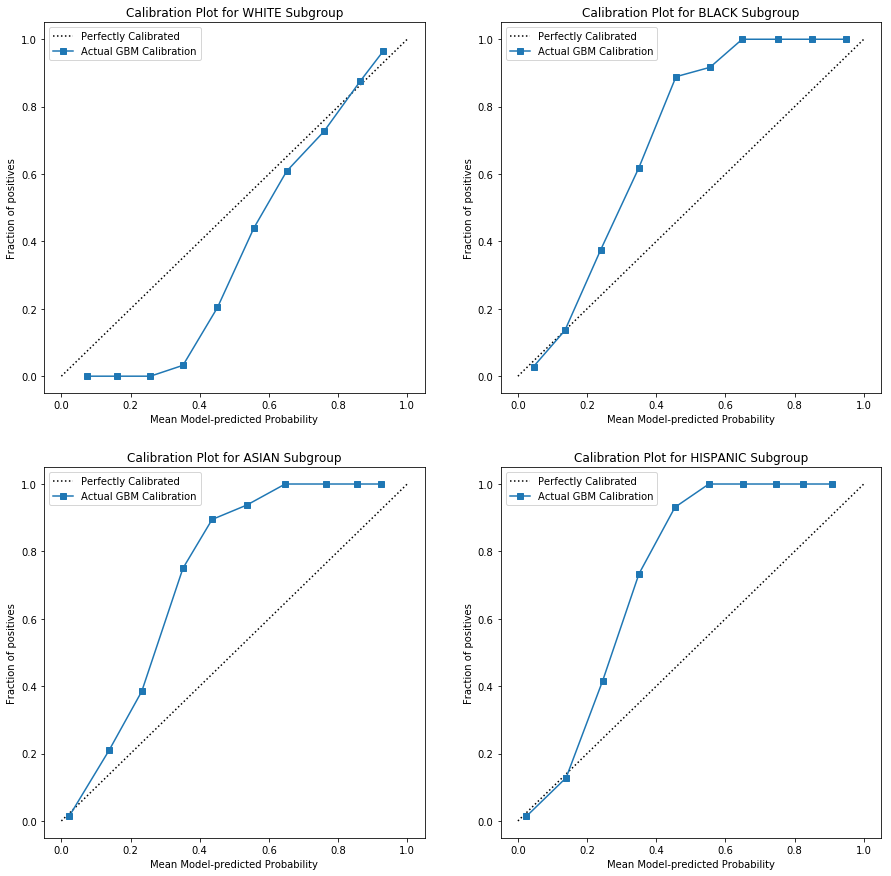

In [69]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, t in enumerate(treatments):
    x = i // 2
    y = i % 2
    
    axs[x][y].plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
    
    T = df_to_T(df, t)
    fraction_of_positives, mean_predicted_value = calibration_curve(T, all_clfs[t].predict_proba(X)[:, 1], n_bins=10)
    axs[x][y].plot(mean_predicted_value, fraction_of_positives, "s-", label="Actual GBM Calibration")

    axs[x][y].set_ylabel("Fraction of positives")
    axs[x][y].set_ylim([-0.05, 1.05])
    axs[x][y].set_xlabel("Mean Model-predicted Probability")
    axs[x][y].legend(loc="upper left")
    axs[x][y].set_title('Calibration Plot for {} Subgroup'.format(t))

### Checking for Common Support

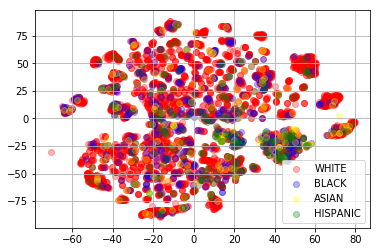

In [70]:
# using t-SNE approach from class
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

num_patients = 5000

# project the covariates into a 2-dimensional representation that can be plotted
plot_X = X[:num_patients]
reshaped_X = TSNE(n_components=2).fit_transform(plot_X)

# now plot the projected covariates colored by treatment
colors=['red', 'blue', 'yellow', 'green']
fig, ax = plt.subplots()

for i, t in enumerate(treatments):
    T = df_to_T(df, t)[:num_patients]
    treatment = (T == 1)
    treated_X = reshaped_X[treatment]
    ax.scatter(treated_X[:,0], treated_X[:,1], c=colors[i], label=t, alpha=0.3)

ax.legend()
ax.grid(True)

In [ ]:
# using box-plot approach from paper

### Checking for Balance

In [65]:
# compute unweighted mean and standard deviation of each covariate for the pooled sample across all treatments
population_covariate_means = np.array(X.mean(axis=0))
population_covariate_stds = np.array(X.std(axis=0))
    
for t in treatments:
    T = df_to_T(df, t)
    X_treated = X[T == 1]
    prop_weights = all_prop_weights[t]
    
    # compare the subpopulation that got this treatment before and after weighting to the unweighted full population
    covariates = np.array(X_treated)
    weights = prop_weights.reshape((len(prop_weights), 1))
    weighted_covariates = np.multiply(covariates, weights)
    
    unweighted_covariate_means = np.array(covariates.mean(axis=0))
    weighted_covariate_means = np.array(weighted_covariates.mean(axis=0))
    
    # for this balance check, we use the population standard bias metric
    PSB_before = np.divide(np.abs(unweighted_covariate_means - population_covariate_means), population_covariate_stds)
    PSB_after = np.divide(np.abs(weighted_covariate_means - population_covariate_means), population_covariate_stds)
    
    bad_covariates_before = []
    bad_covariates_after = []
    for i in range(len(PSB)):
        if PSB_before[i] > 0.2:
            bad_covariates_before.append((i, PSB_before[i]))
        if PSB_after[i] > 0.2:
            bad_covariates_after.append((i, PSB_after[i]))

    print("Covariates for {} with Standad Bias > 0.2 Before Weighting: {}".format(t, bad_covariates_before))
    print("Average Standard Covariate Bias for {} Before Weighting: {}".format(t, np.mean(PSB_before)))
    print("Covariates for {} with Standad Bias > 0.2 After Weighting: {}".format(t, bad_covariates_after))
    print("Average Standard Covariate Bias for {} After Weighting: {}".format(t, np.mean(PSB_after)))
    print("----------------------------------------")

Covariates for WHITE with Standad Bias > 0.2 Before Weighting: []
Average Standard Covariate Bias for WHITE Before Weighting: 0.008035231383114046
Covariates for WHITE with Standad Bias > 0.2 After Weighting: []
Average Standard Covariate Bias for WHITE After Weighting: 0.0046823507091681435
----------------------------------------
Covariates for BLACK with Standad Bias > 0.2 Before Weighting: [(0, 0.3169967515111173), (38, 0.25467768781766986), (55, 0.2557137289955265), (117, 0.25756666998804695), (118, 0.32122159224950037)]
Average Standard Covariate Bias for BLACK Before Weighting: 0.06040221594763699
Covariates for BLACK with Standad Bias > 0.2 After Weighting: [(119, 0.3679871758036998), (120, 0.2652408105787271)]
Average Standard Covariate Bias for BLACK After Weighting: 0.04331947988660302
----------------------------------------
Covariates for ASIAN with Standad Bias > 0.2 Before Weighting: [(36, 0.23090349344984692), (81, 0.22951699309248141), (82, 0.3357350669980966), (86, 0.

### Evaluating ATE Significance by Constructing Bootstrapped Confidence Intervals

In [58]:
# function to efficiently compute all pairwise ATEs
def compute_all_pairwise_ates(df, treatments):    
    X = df_to_X(df)
    Y = df_to_Y(df)

    # compute unweighted mean and standard deviation of each covariate for the pooled sample across all treatments
    population_covariate_means = np.array(X.mean(axis=0))
    population_covariate_stds = np.array(X.std(axis=0))

    all_means = {}

    for t in treatments:
        # compute the weighted mean outcome for this treated subpopulation using propensity scores to weight patients
        T = df_to_T(df, t)
        clf = GradBoost(n_estimators=500).fit(X, T)

        treated = (T == 1)
        X_treated = X[treated]
        prop_weights = (len(X_treated) / len(X)) * np.reciprocal(clf.predict_proba(X_treated)[:,1])
        reciprocal = len(X_treated) # np.sum(prop_weights)
        weighted_mean = sum(np.multiply(Y[treated], prop_weights)) / reciprocal

        all_means[t] = weighted_mean
            
    return all_means

In [59]:
# function that bootstraps dataset and calculates weighted means to construct confidence intervals
def compute_bootstrapped_weighted_means(treatments, old_means, sample_rate, num_trials):
    bootsrap_errors = {}
    for key in all_means:
        bootsrap_errors[key] = []

    for _ in range(num_trials):
        # create a bootstrapped sample 
        bootstrapped_df = df.sample(n = int(sample_rate * len(df)), replace=True)

        # compute the weighted means for this new bootstrapped sample
        new_means = compute_all_pairwise_ates(bootstrapped_df, treatments)
        
        for t in new_means:
            bootsrap_errors[t].append(new_means[t] - old_means[t])
            
    for t in bootsrap_errors:
        bootsrap_errors[t].sort()
        print(bootsrap_errors[t])
        i1 = int(0.975 * num_trials)
        i2 = int(0.025 * num_trials)
        print('95% Confidence Interval for {}: [{}, {}]'.format(t, old_means[t] - bootsrap_errors[t][i1],
                                                 old_means[t] - bootsrap_errors[t][i2]))

In [55]:
num_bootstrap_trials = 5 # use 50 for actual data
bootsrap_sampling_rate = 1

t1 = time.time()
compute_bootstrapped_weighted_means(treatments, all_means, bootsrap_sampling_rate, num_bootstrap_trials)
t2 = time.time()

[-0.06116353562742649, -0.021813840238455118, 0.009913586855812229, 0.00992128534381842, 0.013778418966785333]
Interval for WHITE: [1.8725988412980967, 1.9043339668803703]
[-0.28363349742326527, -0.25759365372178755, -0.24793179836603263, -0.24680238376385621, -0.13884423732979334]
Interval for BLACK: [1.4884264665818865, 1.4992177365398178]
[-0.38600619646878487, -0.3137968440940516, -0.2168771231643467, -0.20574185187201122, -0.164898469810994]
Interval for ASIAN: [1.0583449728123822, 1.1663999650344228]
[-0.21225064339189903, -0.201578566485191, -0.1928329573645623, -0.1575944501938521, -0.13536877661982638]
Interval for HISPANIC: [1.0490465735897196, 1.0930306898810587]


In [56]:
print(t2 - t1)

176.47981309890747


Takes 3 minutes to run 5 bootstrapped samples, so 50 should be reasonable